# SVM Exercise


In machine learning, _support-vector machines_ (_SVMs_) are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis. Given a set of training examples, each marked as belonging to one of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a binary linear classifier. SVM maps training examples to points in space so as to maximise the width of the gap between the two categories. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.


The targe tof this assignment is to develop classifiers, including linear and nonlinear SVM, for [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit classification.


## Table of Contents

- [1-Packages](#1)
- [2-Load the Dataset](#2)
- [3-Skeleton of SVM](#3)
- [4-Linear SVM](#4)
- [5-Non-linear SVM](#5)
- [6-Implementaion with sklearn](#6)

<a name='1'></a>

## 1 - Packages

First import all the packages needed during this assignment


In [1]:
import subprocess
import struct
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import datetime as dt
from itertools import combinations

%matplotlib inline

%load_ext autoreload
%autoreload 2

<a name='2'></a>

## 2 - Load the Dataset


In [2]:
remote_url = 'http://yann.lecun.com/exdb/mnist/'
files = ('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
         't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

save_path = 'mnist'
os.makedirs(save_path, exist_ok=True)

# Download MNIST dataset
for file in files:
    data_path = os.path.join(save_path, file)
    if not os.path.exists(data_path):
        url = remote_url + file
        print(f'Downloading {file} from {url}')
        subprocess.call(['wget', '--quiet', '-O', data_path, url])
        print(f'Finish downloading {file}')

# Extract zip files
subprocess.call(f'find {save_path}/ -name "*.gz" | xargs gunzip -f', shell=True)

Finish downloading train-images-idx3-ubyte.gz
Finish downloading train-labels-idx1-ubyte.gz
Finish downloading t10k-images-idx3-ubyte.gz
Finish downloading t10k-labels-idx1-ubyte.gz


0

In [3]:
mnist_prefixs = ['train_images', 'train_labels', 't10k_images', 't10k_labels']
result = dict.fromkeys(mnist_prefixs)

for file in os.listdir(save_path):
    with open(os.path.join(save_path, file), 'rb') as f:
        prefix = '_'.join(file.split('-')[:2])
        if 'labels' in prefix:
            magic_num, size = struct.unpack('>II', f.read(8))
            result[prefix] = np.fromfile(f, dtype=np.uint8)
        elif 'images' in prefix:
            magic_num, size, rows, cols = struct.unpack('>IIII', f.read(16))
            # reshape to column vector
            result[prefix] = np.fromfile(f, dtype=np.uint8).reshape(size, -1) / 255
        else:
            raise Exception(f'Unexpected filename: {file}')

train_img, train_label, test_img, test_label = (result[key] for key in mnist_prefixs)

In [4]:
# As a sanity check, print out the size of the training and test data
print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_label.shape)
print('Test data shape: ', test_img.shape)
print('Test labels shape: ', test_label.shape)

Training data shape:  (60000, 784)
Training labels shape:  (60000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


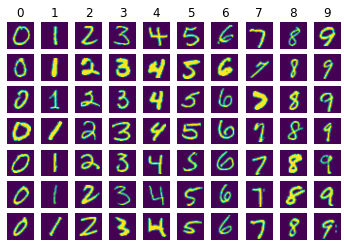

In [5]:
# Visualize some examples from the dataset
classes = list(range(0, 10))
num_classes = len(classes)
sample_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_label == cls)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx)
        img_size = int(np.sqrt(train_img[idx].shape[-1]))
        plt.imshow(train_img[idx].reshape(img_size, img_size))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

<a name='3'></a>

## 3 - Backbone of SVM

In the section, we would implement a soft margin SVM from scratch using simplified SMO algorithm for training SVM. THe details are discussed below.

Recall that a support vector machine computes a linear classifier of the form

$$
f(x)=\omega^{T}x+b
$$

Since we want to apply this to a binary classification problem, we will ultimately predict $y=1$ if $f(x) \geq 0$ and $y=-1$ if $f(x)<0$. By looking at the dual problem, we see that this can also be expressed using inner products as

$$
f(x)=\sum_{i=1}^{m} \alpha_{i} y^{(i)}\left\langle x^{(i)}, x\right\rangle+b
$$

where we can substitute a kernel $K(x^{(i)}, x)$ in place of the inner product if we so desire.

Normally, we wish to solve the dual problem of the support vector mahine optimization problem

$$
\begin{aligned}
\max _{\alpha} \quad & W(\alpha)=\sum_{i=1}^{m} \alpha_{i}-\frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_{i} \alpha_{j}\left\langle x^{(i)}, x^{(j)}\right\rangle \\
\text { subject to } \quad & 0 \leq \alpha_{i} \leq C, \quad i=1, \ldots, m \\
& \sum_{i=1}^{m} \alpha_{i} y^{(i)}=0
\end{aligned}
$$

The problem above can be solved by the _SMO algorithm_. However, the full SMO algorithm contains many optimiations designed to speed up the algorithm on large datasets and ensure that the algorithm converges even under degenereate conditions. For convenience, a simplier version of the version of the algorithm, called the _Simplied SMO algorithm_, is adopted is this exercise. An explanation of the algorithm can be found on [http://cs229.stanford.edu/materials/smo.pdf](http://cs229.stanford.edu/materials/smo.pdf).

In [6]:
def smo(X, Y, kernel, C, max_passes=50, tol=1e-3, max_iter=-1):
    """
    Args:
        X, Y: data
        C: regularization parameter
        tol: numerical tolerance
        max_passes: max # of times to iterate over alpha's without changing
        max_iter: hard limit on iterations within solver, or -1 for no limit

    Returns:
        alpha: Lagrange multipliers for the solution
        b: threshold for the solution
    """
    n, _ = X.shape  # number of examples

    alpha = np.zeros((n,))
    b = 0.0

    E = np.zeros_like(alpha)  # store prediction error
    
    # calculate kernel value between examples
    kernel_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel_matrix[i, j] = kernel(X[i, :], X[j, :])

    def _predict(idx):
        return np.dot(alpha * Y, kernel_matrix[idx])

    def _random_pick(excluded):
        l = list(range(n))
        seq = l[:excluded] + l[excluded + 1:]  # exclude one from choices
        return random.choice(seq)

    num_iter = 0

    passes = 0
    while passes < max_passes:
        num_iter += 1
        if max_iter != -1 and num_iter > max_iter:
            break
        
        alpha_pairs_changed = 0
        alpha_prev = np.copy(alpha)
        for i in range(n):
            E[i] = _predict(idx=i) - Y[i]
            if ((Y[i] * E[i] < -tol and alpha[i] < C) or (Y[i] * E[i] > tol and alpha[i] > 0)):
                j = _random_pick(excluded=i)
                E[j] = _predict(idx=j) - Y[j]

                # compute L and H
                if Y[i] != Y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])

                if L == H:
                    continue

                # compute eta
                eta = 2 * kernel(X[i, :], X[j, :]) - kernel(X[i, :], X[i, :]) - kernel(X[j, :], X[j, :])
                if eta >= 0:
                    continue

                # clip value
                alpha[j] = alpha_prev[j]-((Y[j]*(E[i]-E[j]))/eta)
                alpha[j] = min(alpha[j], H)
                alpha[j] = max(alpha[j], L)

                if abs(alpha[j] - alpha_prev[j]) < tol:
                    continue

                # determine value for alpha_i
                alpha[i] += (Y[i]*Y[j]*(alpha_prev[j] - alpha[j]))

                ii = kernel(X[i, :], X[i, :])
                ij = kernel(X[i, :], X[j, :])
                jj = kernel(X[j, :], X[j, :])

                b1 = b-E[i] - (Y[i]*ii*(alpha[i]-alpha_prev[i])) - \
                    (Y[j]*ij*(alpha[j]-alpha_prev[j]))
                b2 = b-E[j] - (Y[i]*ij*(alpha[i]-alpha_prev[i])) - \
                    (Y[j]*jj*(alpha[j]-alpha_prev[j]))

                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1+b2)/2.0

                alpha_pairs_changed += 1
        if alpha_pairs_changed == 0:
            passes += 1
        else:
            passes = 0

    del kernel_matrix
    
    return alpha, b

In [7]:
class SVM:

    def __init__(self, kernel, C=1.0, max_passes=50, tol=1e-3, max_iter=-1):
        """
        Args:
            C: regularization parameter
            kernel: callable, the kernel to be used in the algorithm
            tol: tolerance for stopping criterion
            max_passes: max # of times to iterate over alpha's without changing
            max_iter: hard limit on iterations within solver, or -1 for no limit
        """
        self.kernel = kernel
        self.C = C
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.tol = tol
        
        self.alpha = None

        self.w = None
        self.b = None

    def fit(self, X, Y):
        alpha, _ = smo(X, Y, self.kernel, self.C, self.max_passes, self.tol, self.max_iter)
        self.alpha = alpha
        self.w, self.b = self._compute_parameters(alpha, X, Y)

    def predict(self, X, with_sgn=True):
        assert self.w is not None, 'self.w is not initialized, use fit() before making predictions'
        assert self.b is not None, 'self.b is not initialized, use fit() before making predicitons'

        pred = np.dot(X, self.w) + self.b
        if with_sgn:
            pred = np.sign(pred)
        return pred

    def _compute_parameters(self, alpha, X, Y):
        w = np.sum(X * (alpha * y).reshape(-1, 1), axis=0)  # using broadcast
        w = w.reshape(-1, 1)  # reshape to dim * 1
        support_vector_indices = np.where(alpha > 0)
        b = np.mean(Y[support_vector_indices] - np.dot(X[support_vector_indices], w))
        return w, b

<a name='4'></a>

## 4 - Linear SVM


In [8]:
# helper functions
def oneVsOneTraining(X, Y, kernel):
    models = dict()

    classes = np.arange(0, 10)
    for (ca, cb) in combinations(classes, 2):  # regard `ca` as positive class and `cb` as negative
        mask = np.logical_or(Y == ca, Y == cb)
        X_sub, Y_sub = X[mask], Y[mask]
        Y_sub = np.where(Y_sub == ca, 1, -1)  # map label to 1/-1
        model = SVM(kernel, C=1.0, max_passes=50, tol=1e-3, max_iter=50)  # restrict max iterations to 50
        start_time = dt.datetime.now()
        print('Start training SVM {}v{} at {}'.format(ca, cb, str(start_time)))
        model.fit(X_sub, Y_sub)
        models[(ca, cb)] = model
    return models

def oneVsOneEvaluation(models, X, Y):
    classes = np.arange(0, 10)
    predictions = []
    for (ca, cb) in combinations(classes, 2):
        model = models[(ca, cb)]
        pred = model.predict(X, with_sgn=True)  # reshape to 1dim array
        pred = np.where(pred == 1, ca, cb)  # map to 0-9 label
        predictions.append(pred)
    predictions = np.hstack(predictions)
    output = np.apply_along_axis(lambda x: np.bincount(x, minlength=10).argmax(), axis=1, arr=predictions)  # voting
    accuracy = np.mean(output == Y)
    return accuracy

In [9]:
linear_kernel = lambda x,y: np.dot(x, y.T)  # linear kernel

models = oneVsOneTraining(train_img, train_label, kernel=linear_kernel)
acc_train = oneVsOneEvaluation(models, train_img, train_label)  # compute accuracy on training set
acc_test = oneVsOneEvaluation(models, test_img, test_label)  # compute accuracy on testing set

print('train accuracy: {:.2f} %'.format(acc_train * 100))
print('test accuracy: {:.2f} %'.format(acc_test * 100))

Start training SVM 0v1 at 2021-10-23 18:32:28.933191
Start training SVM 0v2 at 2021-10-23 18:38:45.549699
Start training SVM 0v3 at 2021-10-23 18:44:14.093678
Start training SVM 0v4 at 2021-10-23 18:49:29.063066
Start training SVM 0v5 at 2021-10-23 18:54:03.187855
Start training SVM 0v6 at 2021-10-23 18:59:46.183901
Start training SVM 0v7 at 2021-10-23 19:04:31.878454
Start training SVM 0v8 at 2021-10-23 19:10:08.799608
Start training SVM 0v9 at 2021-10-23 19:15:12.285418
Start training SVM 1v2 at 2021-10-23 19:20:13.462228
Start training SVM 1v3 at 2021-10-23 19:26:53.207136
Start training SVM 1v4 at 2021-10-23 19:33:09.582665
Start training SVM 1v5 at 2021-10-23 19:41:42.273000
Start training SVM 1v6 at 2021-10-23 19:51:11.414305
Start training SVM 1v7 at 2021-10-23 20:01:14.486300
Start training SVM 1v8 at 2021-10-23 20:12:06.793389
Start training SVM 1v9 at 2021-10-23 20:27:58.683931
Start training SVM 2v3 at 2021-10-23 20:38:23.274372
Start training SVM 2v4 at 2021-10-23 20:52:05.

<a name='5'></a>

## 5 - Non-linear SVM

In [10]:
gamma = 1/2000
rbf_kernel = lambda x,y: np.exp(-gamma * np.sum((y - x) ** 2, axis=-1))  # rbf kernel

models = oneVsOneTraining(train_img, train_label, kernel=rbf_kernel)
acc_train = oneVsOneEvaluation(models, train_img, train_label)  # compute accuracy on training set
acc_test = oneVsOneEvaluation(models, test_img, test_label)  # compute accuracy on testing set

print('train accuracy: {:.2f} %'.format(acc_train * 100))
print('test accuracy: {:.2f} %'.format(acc_test * 100))

Start training SVM 0v1 at 2021-10-23 23:52:10.199213
Start training SVM 0v2 at 2021-10-24 00:17:15.225631
Start training SVM 0v3 at 2021-10-24 00:39:51.663716
Start training SVM 0v4 at 2021-10-24 01:03:05.071439
Start training SVM 0v5 at 2021-10-24 01:24:53.445706
Start training SVM 0v6 at 2021-10-24 01:45:40.937090
Start training SVM 0v7 at 2021-10-24 02:07:59.232200
Start training SVM 0v8 at 2021-10-24 02:31:16.032991
Start training SVM 0v9 at 2021-10-24 02:53:25.548832
Start training SVM 1v2 at 2021-10-24 03:15:42.852153
Start training SVM 1v3 at 2021-10-24 03:41:18.791407
Start training SVM 1v4 at 2021-10-24 04:07:27.102340
Start training SVM 1v5 at 2021-10-24 04:32:32.494992
Start training SVM 1v6 at 2021-10-24 04:55:49.475938
Start training SVM 1v7 at 2021-10-24 05:21:17.784206
Start training SVM 1v8 at 2021-10-24 05:48:02.638439
Start training SVM 1v9 at 2021-10-24 06:12:53.216122
Start training SVM 2v3 at 2021-10-24 06:38:23.639243
Start training SVM 2v4 at 2021-10-24 07:01:39.

<a name='6'></a>

## 6 - Implementation with sklearn

In section 4 and 5, we implemented linear and non-linear svm from scratch using simplified smo algorithm. However, the training is extremely time-consuming and the accuracy is quite low. The reasons are manifold, such as the limit of simplified smo itself (noted that we restrict the iterations to 50 to avoid long waiting, leading to early stopping of the algorithm), and the hyperparameters we uesd in the kernel.

It is highly recommended to build svm with modern libraries. In this section, we will build svm using the `sklearn-learn` library. With its simple api design and its built-in optimization technique, we can get a high accuracy but in a much shorter time.

In [11]:
from sklearn import svm

# Linear SVM
linear_classifier = svm.SVC(kernel='linear')  # using default C=1.0, tol=1e-3

start_time = dt.datetime.now()
print('Start training at {}'.format(str(start_time)))
linear_classifier.fit(train_img, train_label)
end_time = dt.datetime.now() 
print('Stop training at {}'.format(str(end_time)))
elapsed_time = end_time - start_time
print('Elapsed training time: {}'.format(str(elapsed_time)))

pred_train = linear_classifier.predict(train_img)
pred_test = linear_classifier.predict(test_img)

acc_train = np.mean(pred_train == train_label)
acc_test = np.mean(pred_test == test_label)

print('train accuracy: {:.2f} %'.format(acc_train * 100))
print('test accuracy: {:.2f} %'.format(acc_test * 100))

Start training at 2021-10-24 17:46:39.280875
Stop training at 2021-10-24 17:51:36.669788
Elapsed training time: 0:04:57.388913
train accuracy: 97.08 %
test accuracy: 94.04 %


In [12]:
# Non-linear SVM
rbf_classifier = svm.SVC(kernel='rbf')  # using default C=1.0, tol=1e-3
start_time = dt.datetime.now()
print('Start training at {}'.format(str(start_time)))
rbf_classifier.fit(train_img, train_label)
end_time = dt.datetime.now() 
print('Stop training at {}'.format(str(end_time)))
elapsed_time = end_time - start_time
print('Elapsed training time: {}'.format(str(elapsed_time)))

pred_train = rbf_classifier.predict(train_img)
pred_test = rbf_classifier.predict(test_img)

acc_train = np.mean(pred_train == train_label)
acc_test = np.mean(pred_test == test_label)

print('train accuracy: {:.2f} %'.format(acc_train * 100))
print('test accuracy: {:.2f} %'.format(acc_test * 100))

Start training at 2021-10-24 18:06:22.371095
Stop training at 2021-10-24 18:09:31.504513
Elapsed training time: 0:03:09.133418
train accuracy: 98.99 %
test accuracy: 97.92 %
